In [1]:
import pandas as pd
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-05-04 13:34:12.953643: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 13:34:12.953880: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 13:34:12.955633: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 13:34:12.977171: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 13:34:13.533893: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
# # Loading the dataset (using the downloaded file)
# path = "/content/drive/MyDrive/Colab Notebooks/DATA255_Assignment/IMDB_Dataset.csv"
# df = pd.read_csv(path)

In [4]:
df= pd.read_csv("IMDB_Dataset.csv")
df.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
##cleaning up the text
stopWords = set(nltk.corpus.stopwords.words("english"))
def CleanText(text):
    text = text.lower()
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"]=df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

In [7]:
### converting 1000 most frequent words to integer
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)

tokenizer.fit_on_texts(Data)

IntegerizedData = pd.Series(tokenizer.texts_to_sequences(Data))
IntegerizedData.head()

0    [315, 6873, 3237, 2, 117, 996, 1569, 1033, 117...
1    [342, 2080, 100, 30, 3711, 232, 11, 66, 165, 5...
2    [20, 595, 4986, 24, 8579, 369, 844, 7247, 2536...
3    [8, 5767, 24, 749, 582, 180, 304, 147, 2329, 2...
4    [8836, 1155, 25, 3325, 521, 11, 535, 9224, 920...
dtype: object

In [8]:
### You can convert the sequences back to the string
tokenizer.sequences_to_texts(IntegerizedData[0:1])

['mr costner dragged movie far longer necessary aside terrific sea rescue sequences care characters us ghosts closet costner character realized early forgotten much later time care character really care cocky ashton kutcher problem comes kid thinks better anyone else around shows signs closet appears winning costner finally well past half way point stinker costner tells us kutcher ghosts told kutcher driven best prior magic could keep turning hour']

In [9]:
DataLength=IntegerizedData.apply(lambda x: len(x))
DataLength.describe()

count    50000.000000
mean       110.157100
std         81.213625
min          3.000000
25%         60.000000
50%         83.000000
75%        135.000000
max       1104.000000
dtype: float64

The average length of reviews is 110, the shortest review length is 3 and the longest is 1104.

Therefore we need to pad the sequences to equal length.

The following padding function performs zero padding if the length of a sequence is less than the threshold and truncate the ones which are longer than threshold to the threshold.  We choose the threshold to be 256.

In [10]:
#zero padding
IntegerizedData= pad_sequences(IntegerizedData, maxlen=256)


In [11]:
IntegerizedData

array([[   0,    0,    0, ...,  269, 1456,  397],
       [   0,    0,    0, ...,  363,    3,   80],
       [   0,    0,    0, ...,   54,   57,   76],
       ...,
       [   0,    0,    0, ...,  973,   99, 9907],
       [   0,    0,    0, ..., 8508, 3506,   13],
       [   0,    0,    0, ...,   11, 2263,   23]], dtype=int32)

In [12]:
x_train_val,x_test,y_train_val,y_test = train_test_split(IntegerizedData,labels,stratify=labels,test_size=0.20, random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,stratify=y_train_val,test_size=0.10, random_state=42)

In [13]:
type(x_val)

numpy.ndarray

In [14]:
print(y_train.shape,y_val.shape,y_test.shape)

(36000,) (4000,) (10000,)


## now you have your training, validation and test set as numpy arrays, you can implement the networks

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader
import time

In [16]:
class LSTM_c(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_dim, output_dim):
        super(LSTM_c, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.global_maxpool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        pooled = self.global_maxpool(lstm_out.permute(0, 2, 1)).squeeze(2)
        fc1_out = self.relu(self.fc1(pooled))
        fc2_out = self.sigmoid(self.fc2(fc1_out))
        return fc2_out

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1/80, Time: 0.86s, Train Loss: 0.6948, Val Loss: 0.6936, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 2/80, Time: 0.64s, Train Loss: 0.6931, Val Loss: 0.6929, Train Accuracy: 0.5045, Val Accuracy: 0.5218
Epoch 3/80, Time: 0.63s, Train Loss: 0.6922, Val Loss: 0.6917, Train Accuracy: 0.5451, Val Accuracy: 0.5942
Epoch 4/80, Time: 0.64s, Train Loss: 0.6893, Val Loss: 0.6850, Train Accuracy: 0.6242, Val Accuracy: 0.6538
Epoch 5/80, Time: 0.64s, Train Loss: 0.6670, Val Loss: 0.6303, Train Accuracy: 0.6602, Val Accuracy: 0.6823
Epoch 6/80, Time: 0.63s, Train Loss: 0.6004, Val Loss: 0.5708, Train Accuracy: 0.6973, Val Accuracy: 0.7163
Epoch 7/80, Time: 0.64s, Train Loss: 0.5545, Val Loss: 0.5379, Train Accuracy: 0.7288, Val Accuracy: 0.7332
Epoch 8/80, Time: 0.88s, Train Loss: 0.5235, Val Loss: 0.5145, Train Accuracy: 0.7505, Val Accuracy: 0.7505
Epoch 9/80, Time: 0.88s, Train Loss: 0.4997, Val Loss: 0.4938, Train Accuracy: 0.7648, Val Accuracy: 0.7658
Epoch 10/80, Time: 0.88s, Tr

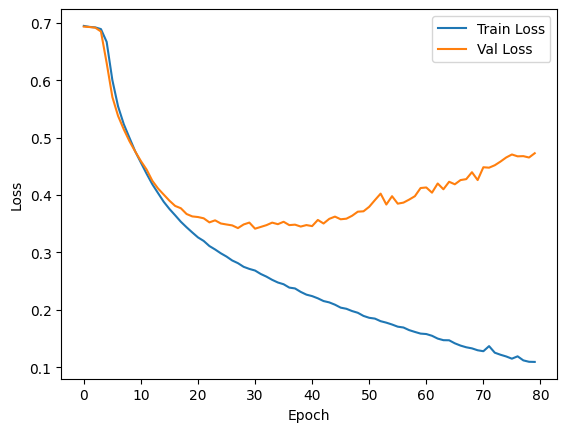

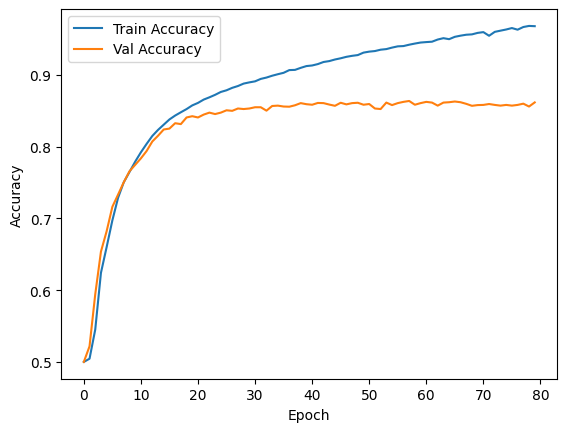

Test Accuracy: 0.8496


In [17]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80

# Instantiate the model and move it to GPU
model = LSTM_c(embedding_dim=embedding_dim, vocab_size=frequentWord, hidden_dim=hidden_dim, output_dim=1).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # Unsqueeze to match dimensions
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels.unsqueeze(1)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()

# Convert y_test to the same data type as y_pred
y_test_np = y_test.values.astype(np.float32)

# Calculate test accuracy
test_accuracy = np.mean(y_pred.squeeze() == y_test_np)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 1e-3

Epoch 1/80, Time: 0.84s, Train Loss: 0.6997, Val Loss: 0.6970, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 2/80, Time: 0.87s, Train Loss: 0.6957, Val Loss: 0.6949, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 3/80, Time: 0.85s, Train Loss: 0.6942, Val Loss: 0.6939, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 4/80, Time: 0.84s, Train Loss: 0.6936, Val Loss: 0.6936, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 5/80, Time: 1.10s, Train Loss: 0.6934, Val Loss: 0.6934, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 6/80, Time: 0.85s, Train Loss: 0.6932, Val Loss: 0.6932, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 7/80, Time: 0.84s, Train Loss: 0.6931, Val Loss: 0.6931, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 8/80, Time: 0.84s, Train Loss: 0.6930, Val Loss: 0.6930, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 9/80, Time: 0.86s, Train Loss: 0.6928, Val Loss: 0.6928, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 10/80, Time: 0.85s, Tr

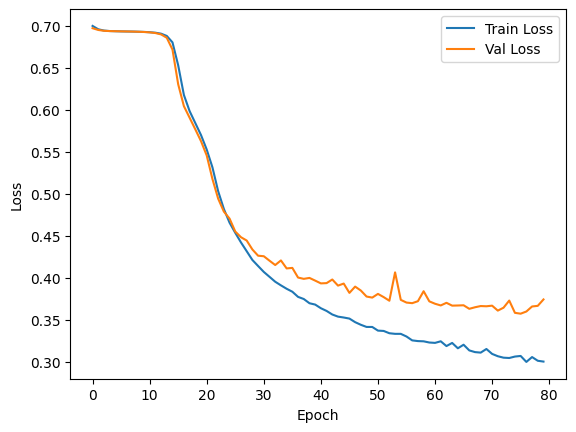

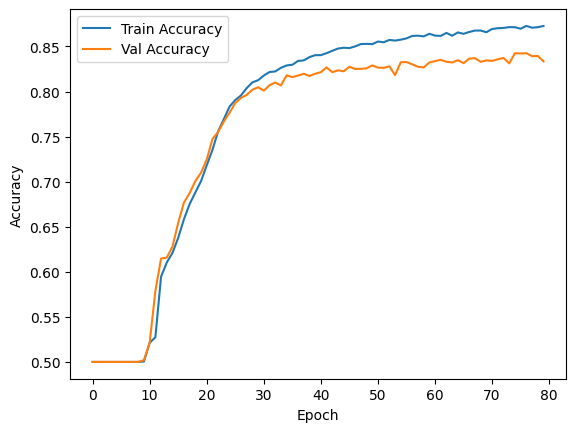

Test Accuracy: 0.8352


In [18]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80
weight_decay = 1e-3

# Instantiate the model and move it to GPU
model = LSTM_c(embedding_dim=embedding_dim, vocab_size=frequentWord, hidden_dim=hidden_dim, output_dim=1).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # Unsqueeze to match dimensions
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels.unsqueeze(1)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()

# Convert y_test to the same data type as y_pred
y_test_np = y_test.values.astype(np.float32)

# Calculate test accuracy
test_accuracy = np.mean(y_pred.squeeze() == y_test_np)
print(f'Test Accuracy: {test_accuracy:.4f}')

## Adding dropout with probability of 0.15

In [19]:
import torch.nn as nn

class LSTM_c_dropout(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_dim, output_dim):
        super(LSTM_c_dropout, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(p=0.15)  # Dropout layer added
        self.global_maxpool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)  # Applying dropout to the embedded input
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)  # Applying dropout to the LSTM output
        pooled = self.global_maxpool(lstm_out.permute(0, 2, 1)).squeeze(2)
        fc1_out = self.relu(self.fc1(pooled))
        fc2_out = self.sigmoid(self.fc2(fc1_out))
        return fc2_out


Epoch 1/80, Time: 0.87s, Train Loss: 0.6965, Val Loss: 0.6951, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 2/80, Time: 0.84s, Train Loss: 0.6937, Val Loss: 0.6934, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 3/80, Time: 0.85s, Train Loss: 0.6929, Val Loss: 0.6931, Train Accuracy: 0.4999, Val Accuracy: 0.5000
Epoch 4/80, Time: 1.12s, Train Loss: 0.6928, Val Loss: 0.6929, Train Accuracy: 0.5001, Val Accuracy: 0.5000
Epoch 5/80, Time: 0.85s, Train Loss: 0.6927, Val Loss: 0.6929, Train Accuracy: 0.5242, Val Accuracy: 0.5000
Epoch 6/80, Time: 0.85s, Train Loss: 0.6927, Val Loss: 0.6929, Train Accuracy: 0.5133, Val Accuracy: 0.5000
Epoch 7/80, Time: 0.85s, Train Loss: 0.6927, Val Loss: 0.6928, Train Accuracy: 0.5126, Val Accuracy: 0.5000
Epoch 8/80, Time: 0.86s, Train Loss: 0.6926, Val Loss: 0.6926, Train Accuracy: 0.5340, Val Accuracy: 0.5000
Epoch 9/80, Time: 0.85s, Train Loss: 0.6926, Val Loss: 0.6927, Train Accuracy: 0.5426, Val Accuracy: 0.5000
Epoch 10/80, Time: 0.85s, Tr

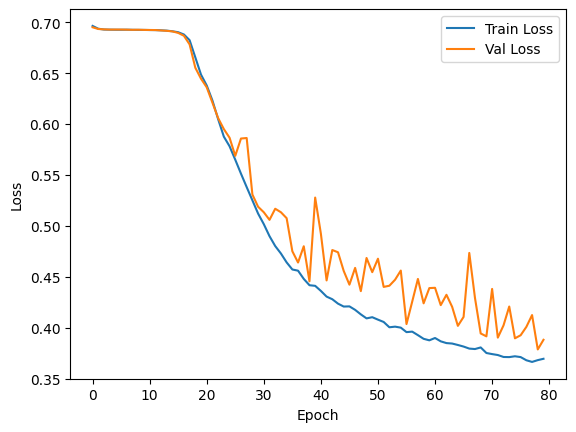

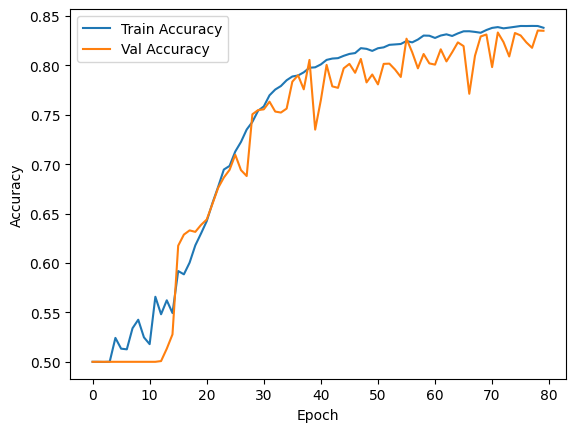

Test Accuracy: 0.8210


In [20]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80
weight_decay = 1e-3

# Instantiate the model and move it to GPU
model = LSTM_c_dropout(embedding_dim=embedding_dim, vocab_size=frequentWord, hidden_dim=hidden_dim, output_dim=1).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # Unsqueeze to match dimensions
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels.unsqueeze(1)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()

# Convert y_test to the same data type as y_pred
y_test_np = y_test.values.astype(np.float32)

# Calculate test accuracy
test_accuracy = np.mean(y_pred.squeeze() == y_test_np)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 7e-4

Epoch 1/80, Time: 0.90s, Train Loss: 0.6940, Val Loss: 0.6936, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 2/80, Time: 0.85s, Train Loss: 0.6933, Val Loss: 0.6933, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 3/80, Time: 0.85s, Train Loss: 0.6931, Val Loss: 0.6932, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 4/80, Time: 0.85s, Train Loss: 0.6930, Val Loss: 0.6930, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 5/80, Time: 0.85s, Train Loss: 0.6928, Val Loss: 0.6929, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 6/80, Time: 0.85s, Train Loss: 0.6925, Val Loss: 0.6925, Train Accuracy: 0.5031, Val Accuracy: 0.5000
Epoch 7/80, Time: 0.85s, Train Loss: 0.6916, Val Loss: 0.6911, Train Accuracy: 0.5166, Val Accuracy: 0.5000
Epoch 8/80, Time: 1.09s, Train Loss: 0.6888, Val Loss: 0.6868, Train Accuracy: 0.5363, Val Accuracy: 0.5140
Epoch 9/80, Time: 0.90s, Train Loss: 0.6806, Val Loss: 0.6748, Train Accuracy: 0.5797, Val Accuracy: 0.6120
Epoch 10/80, Time: 0.85s, Tr

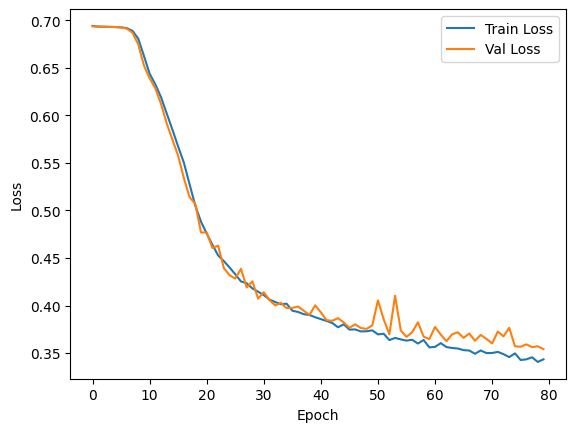

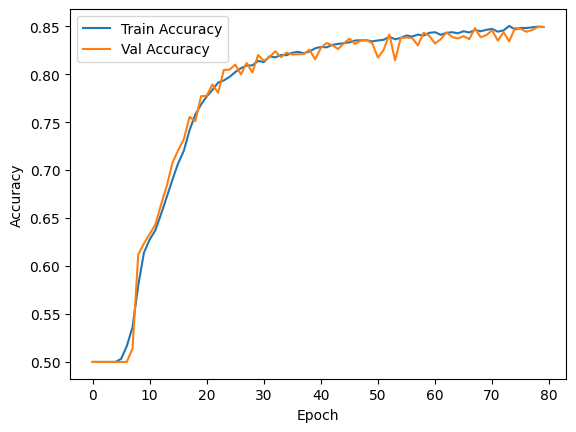

Test Accuracy: 0.8424


In [21]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80
weight_decay = 7e-4

# Instantiate the model and move it to GPU
model = LSTM_c_dropout(embedding_dim=embedding_dim, vocab_size=frequentWord, hidden_dim=hidden_dim, output_dim=1).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # Unsqueeze to match dimensions
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels.unsqueeze(1)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()

# Convert y_test to the same data type as y_pred
y_test_np = y_test.values.astype(np.float32)

# Calculate test accuracy
test_accuracy = np.mean(y_pred.squeeze() == y_test_np)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 5e-4
# Best Graph
## Hyperparameters
## Dropout = 0.15
## L2 Regularization = 5e-4
## Batch Size = 512
## Learning Rate = 0.0001

Epoch 1/140, Time: 0.92s, Train Loss: 0.6933, Val Loss: 0.6928, Train Accuracy: 0.5065, Val Accuracy: 0.5022
Epoch 2/140, Time: 0.89s, Train Loss: 0.6927, Val Loss: 0.6925, Train Accuracy: 0.5413, Val Accuracy: 0.5178
Epoch 3/140, Time: 0.86s, Train Loss: 0.6923, Val Loss: 0.6920, Train Accuracy: 0.5512, Val Accuracy: 0.5873
Epoch 4/140, Time: 0.86s, Train Loss: 0.6912, Val Loss: 0.6905, Train Accuracy: 0.5918, Val Accuracy: 0.6350
Epoch 5/140, Time: 0.85s, Train Loss: 0.6880, Val Loss: 0.6853, Train Accuracy: 0.6133, Val Accuracy: 0.6448
Epoch 6/140, Time: 1.11s, Train Loss: 0.6765, Val Loss: 0.6674, Train Accuracy: 0.6327, Val Accuracy: 0.6318
Epoch 7/140, Time: 0.85s, Train Loss: 0.6522, Val Loss: 0.6412, Train Accuracy: 0.6342, Val Accuracy: 0.6492
Epoch 8/140, Time: 0.87s, Train Loss: 0.6315, Val Loss: 0.6197, Train Accuracy: 0.6520, Val Accuracy: 0.6627
Epoch 9/140, Time: 0.90s, Train Loss: 0.6079, Val Loss: 0.5914, Train Accuracy: 0.6739, Val Accuracy: 0.6900
Epoch 10/140, Time:

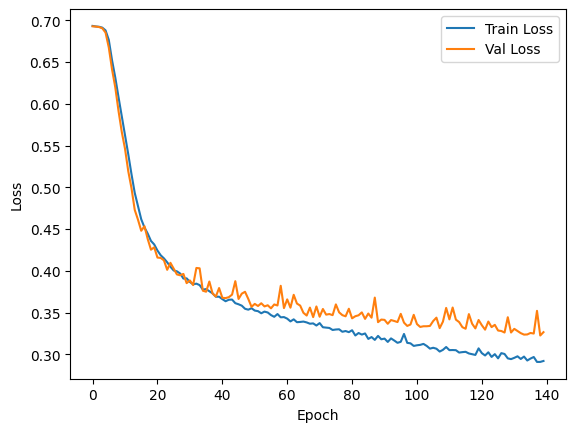

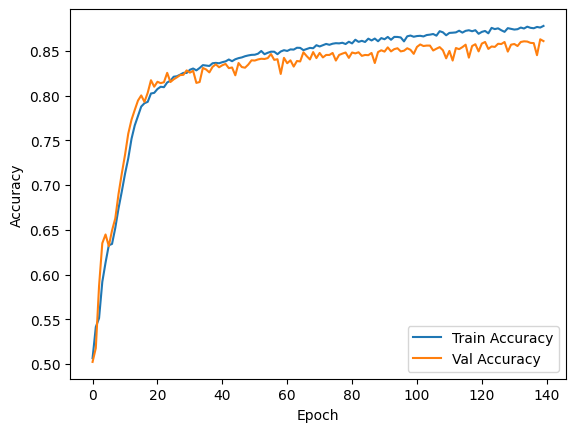

Test Accuracy: 0.8512


In [22]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 140
weight_decay = 5e-4

# Instantiate the model and move it to GPU
model = LSTM_c_dropout(embedding_dim=embedding_dim, vocab_size=frequentWord, hidden_dim=hidden_dim, output_dim=1).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # Unsqueeze to match dimensions
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels.unsqueeze(1)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()

# Convert y_test to the same data type as y_pred
y_test_np = y_test.values.astype(np.float32)

# Calculate test accuracy
test_accuracy = np.mean(y_pred.squeeze() == y_test_np)
print(f'Test Accuracy: {test_accuracy:.4f}')

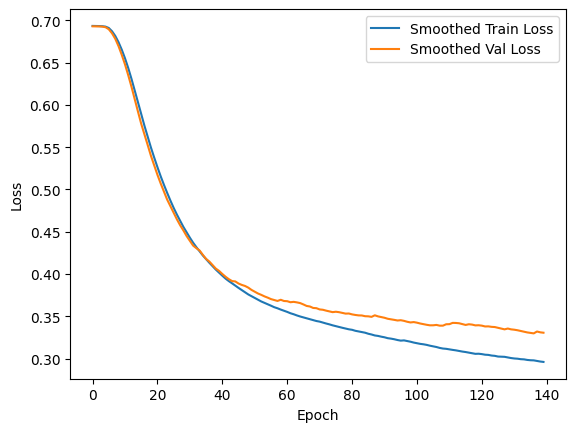

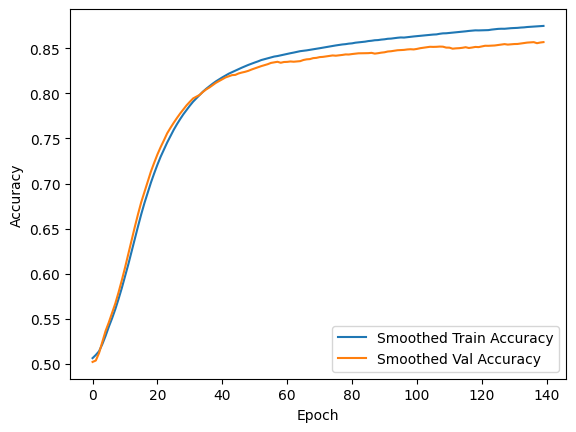

Test Accuracy: 0.8512


In [23]:
### Smoothing out the above graph
import numpy as np
import matplotlib.pyplot as plt

# Define a function for smoothing the data
def smooth_data(data, smoothing_factor=0.9):
    smoothed_data = []
    last_smoothed_point = data[0]
    for point in data:
        smoothed_point = last_smoothed_point * smoothing_factor + point * (1 - smoothing_factor)
        smoothed_data.append(smoothed_point)
        last_smoothed_point = smoothed_point
    return smoothed_data

# Smooth the train and validation losses
smoothed_train_losses = smooth_data(train_losses)
smoothed_val_losses = smooth_data(val_losses)

# Smooth the train and validation accuracies
smoothed_train_accuracies = smooth_data(train_accuracies)
smoothed_val_accuracies = smooth_data(val_accuracies)

# Plotting smoothed train and validation losses
plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
plt.plot(smoothed_val_losses, label='Smoothed Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting smoothed train and validation accuracies
plt.plot(smoothed_train_accuracies, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Smoothed Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate test accuracy
test_accuracy = np.mean(y_pred.squeeze() == y_test_np)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 4e-4

Epoch 1/140, Time: 0.95s, Train Loss: 0.6932, Val Loss: 0.6931, Train Accuracy: 0.4998, Val Accuracy: 0.5000
Epoch 2/140, Time: 0.86s, Train Loss: 0.6931, Val Loss: 0.6930, Train Accuracy: 0.5060, Val Accuracy: 0.5000
Epoch 3/140, Time: 0.86s, Train Loss: 0.6929, Val Loss: 0.6928, Train Accuracy: 0.5096, Val Accuracy: 0.4998
Epoch 4/140, Time: 1.14s, Train Loss: 0.6927, Val Loss: 0.6925, Train Accuracy: 0.5436, Val Accuracy: 0.5025
Epoch 5/140, Time: 0.86s, Train Loss: 0.6920, Val Loss: 0.6914, Train Accuracy: 0.6009, Val Accuracy: 0.5507
Epoch 6/140, Time: 0.87s, Train Loss: 0.6899, Val Loss: 0.6881, Train Accuracy: 0.6255, Val Accuracy: 0.6242
Epoch 7/140, Time: 0.87s, Train Loss: 0.6837, Val Loss: 0.6785, Train Accuracy: 0.6298, Val Accuracy: 0.6348
Epoch 8/140, Time: 0.88s, Train Loss: 0.6684, Val Loss: 0.6563, Train Accuracy: 0.6282, Val Accuracy: 0.6392
Epoch 9/140, Time: 0.89s, Train Loss: 0.6421, Val Loss: 0.6261, Train Accuracy: 0.6353, Val Accuracy: 0.6607
Epoch 10/140, Time:

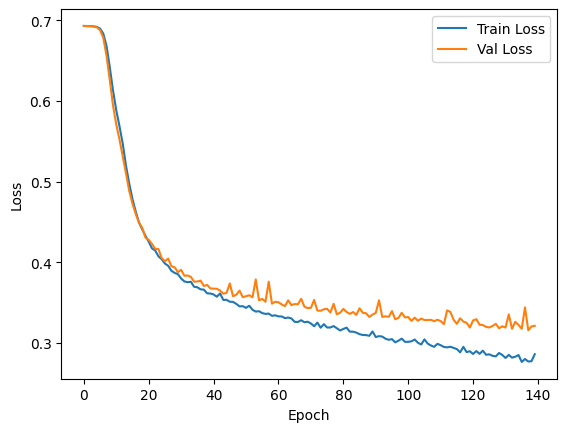

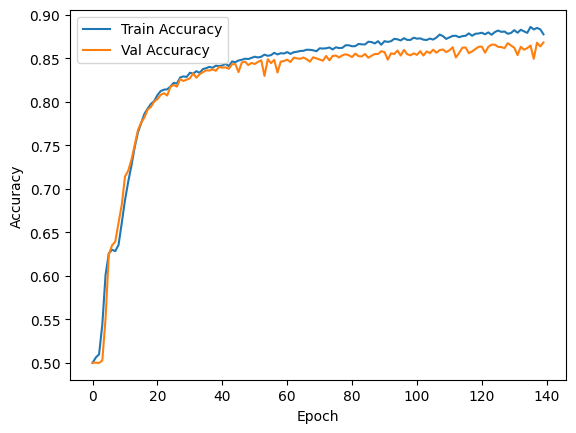

Test Accuracy: 0.8589


In [26]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 140
weight_decay = 4e-4

# Instantiate the model and move it to GPU
model = LSTM_c_dropout(embedding_dim=embedding_dim, vocab_size=frequentWord, hidden_dim=hidden_dim, output_dim=1).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # Unsqueeze to match dimensions
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels.unsqueeze(1)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()

# Convert y_test to the same data type as y_pred
y_test_np = y_test.values.astype(np.float32)

# Calculate test accuracy
test_accuracy = np.mean(y_pred.squeeze() == y_test_np)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 3.8e-4

Epoch 1/150, Time: 0.92s, Train Loss: 0.6972, Val Loss: 0.6956, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 2/150, Time: 0.86s, Train Loss: 0.6941, Val Loss: 0.6938, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 3/150, Time: 0.91s, Train Loss: 0.6932, Val Loss: 0.6934, Train Accuracy: 0.5033, Val Accuracy: 0.5000
Epoch 4/150, Time: 0.89s, Train Loss: 0.6930, Val Loss: 0.6932, Train Accuracy: 0.5001, Val Accuracy: 0.5000
Epoch 5/150, Time: 0.87s, Train Loss: 0.6926, Val Loss: 0.6927, Train Accuracy: 0.5114, Val Accuracy: 0.5000
Epoch 6/150, Time: 0.86s, Train Loss: 0.6920, Val Loss: 0.6919, Train Accuracy: 0.5793, Val Accuracy: 0.5020
Epoch 7/150, Time: 0.87s, Train Loss: 0.6907, Val Loss: 0.6901, Train Accuracy: 0.6110, Val Accuracy: 0.5610
Epoch 8/150, Time: 1.10s, Train Loss: 0.6868, Val Loss: 0.6830, Train Accuracy: 0.6089, Val Accuracy: 0.6368
Epoch 9/150, Time: 0.94s, Train Loss: 0.6689, Val Loss: 0.6505, Train Accuracy: 0.6220, Val Accuracy: 0.6458
Epoch 10/150, Time:

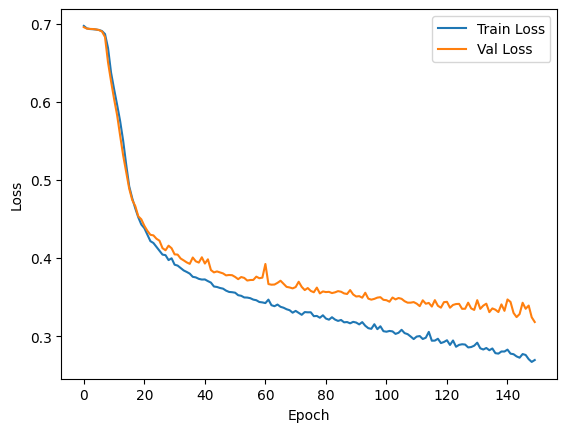

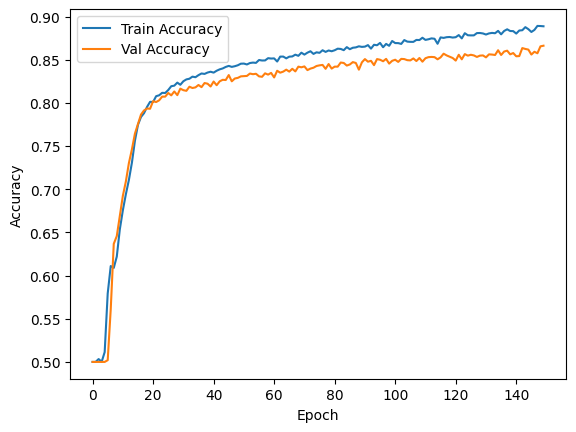

Test Accuracy: 0.8636


In [27]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 150
weight_decay = 3.8e-4

# Instantiate the model and move it to GPU
model = LSTM_c_dropout(embedding_dim=embedding_dim, vocab_size=frequentWord, hidden_dim=hidden_dim, output_dim=1).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # Unsqueeze to match dimensions
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels.unsqueeze(1)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()

# Convert y_test to the same data type as y_pred
y_test_np = y_test.values.astype(np.float32)

# Calculate test accuracy
test_accuracy = np.mean(y_pred.squeeze() == y_test_np)
print(f'Test Accuracy: {test_accuracy:.4f}')

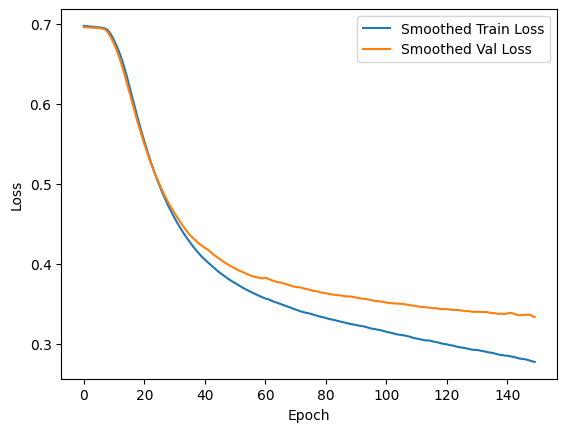

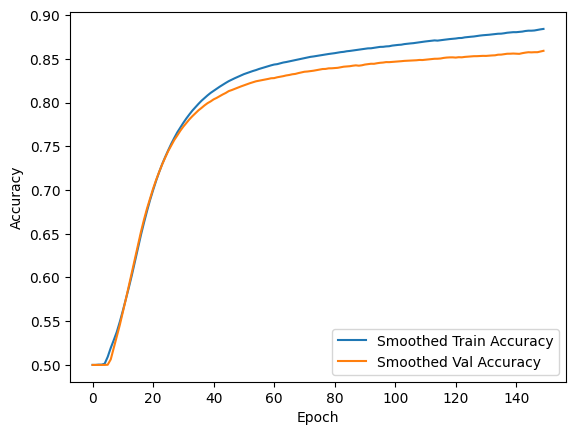

Test Accuracy: 0.8636


In [28]:
### Smoothing out the above graph
import numpy as np
import matplotlib.pyplot as plt

# Define a function for smoothing the data
def smooth_data(data, smoothing_factor=0.9):
    smoothed_data = []
    last_smoothed_point = data[0]
    for point in data:
        smoothed_point = last_smoothed_point * smoothing_factor + point * (1 - smoothing_factor)
        smoothed_data.append(smoothed_point)
        last_smoothed_point = smoothed_point
    return smoothed_data

# Smooth the train and validation losses
smoothed_train_losses = smooth_data(train_losses)
smoothed_val_losses = smooth_data(val_losses)

# Smooth the train and validation accuracies
smoothed_train_accuracies = smooth_data(train_accuracies)
smoothed_val_accuracies = smooth_data(val_accuracies)

# Plotting smoothed train and validation losses
plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
plt.plot(smoothed_val_losses, label='Smoothed Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting smoothed train and validation accuracies
plt.plot(smoothed_train_accuracies, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Smoothed Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate test accuracy
test_accuracy = np.mean(y_pred.squeeze() == y_test_np)
print(f'Test Accuracy: {test_accuracy:.4f}')

____

## L2 Regularization with weight decay of 3e-4

Epoch 1/200, Time: 0.90s, Train Loss: 0.6951, Val Loss: 0.6942, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 2/200, Time: 1.14s, Train Loss: 0.6934, Val Loss: 0.6934, Train Accuracy: 0.5004, Val Accuracy: 0.5000
Epoch 3/200, Time: 0.86s, Train Loss: 0.6931, Val Loss: 0.6932, Train Accuracy: 0.5098, Val Accuracy: 0.5000
Epoch 4/200, Time: 0.85s, Train Loss: 0.6927, Val Loss: 0.6926, Train Accuracy: 0.5227, Val Accuracy: 0.5000
Epoch 5/200, Time: 0.85s, Train Loss: 0.6919, Val Loss: 0.6916, Train Accuracy: 0.5791, Val Accuracy: 0.5035
Epoch 6/200, Time: 0.86s, Train Loss: 0.6899, Val Loss: 0.6883, Train Accuracy: 0.5999, Val Accuracy: 0.5847
Epoch 7/200, Time: 0.86s, Train Loss: 0.6831, Val Loss: 0.6763, Train Accuracy: 0.6089, Val Accuracy: 0.6208
Epoch 8/200, Time: 0.86s, Train Loss: 0.6586, Val Loss: 0.6388, Train Accuracy: 0.6215, Val Accuracy: 0.6378
Epoch 9/200, Time: 0.86s, Train Loss: 0.6215, Val Loss: 0.6017, Train Accuracy: 0.6576, Val Accuracy: 0.6857
Epoch 10/200, Time:

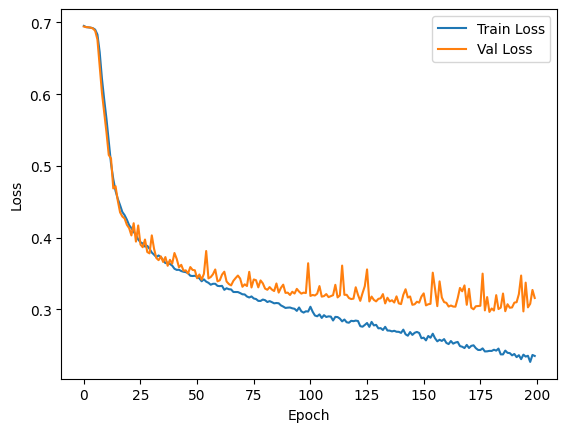

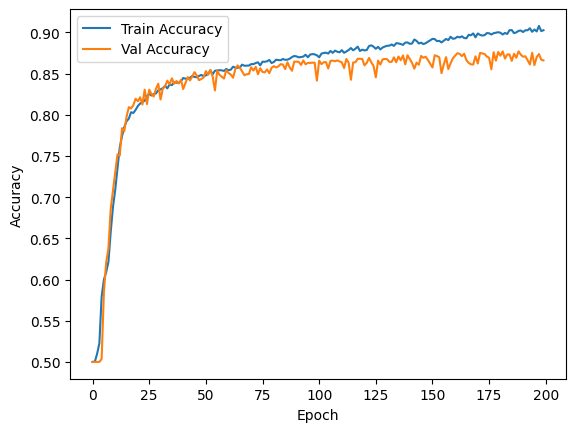

Test Accuracy: 0.8630


In [29]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 200
weight_decay = 3e-4

# Instantiate the model and move it to GPU
model = LSTM_c_dropout(embedding_dim=embedding_dim, vocab_size=frequentWord, hidden_dim=hidden_dim, output_dim=1).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # Unsqueeze to match dimensions
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels.unsqueeze(1)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()

# Convert y_test to the same data type as y_pred
y_test_np = y_test.values.astype(np.float32)

# Calculate test accuracy
test_accuracy = np.mean(y_pred.squeeze() == y_test_np)
print(f'Test Accuracy: {test_accuracy:.4f}')

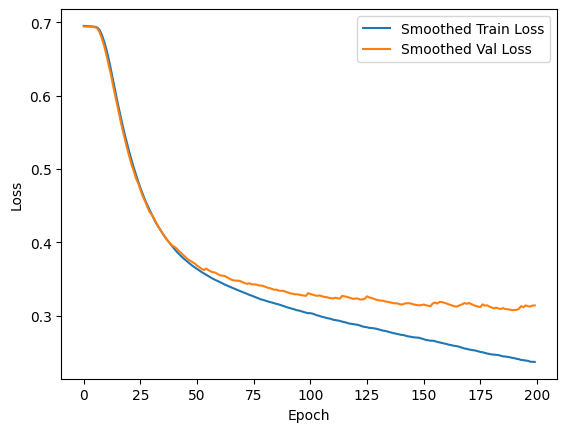

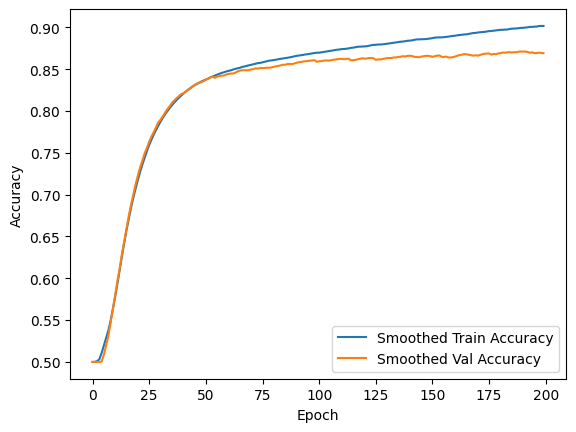

Test Accuracy: 0.8630


In [30]:
### Smoothing out the above graph
import numpy as np
import matplotlib.pyplot as plt

# Define a function for smoothing the data
def smooth_data(data, smoothing_factor=0.9):
    smoothed_data = []
    last_smoothed_point = data[0]
    for point in data:
        smoothed_point = last_smoothed_point * smoothing_factor + point * (1 - smoothing_factor)
        smoothed_data.append(smoothed_point)
        last_smoothed_point = smoothed_point
    return smoothed_data

# Smooth the train and validation losses
smoothed_train_losses = smooth_data(train_losses)
smoothed_val_losses = smooth_data(val_losses)

# Smooth the train and validation accuracies
smoothed_train_accuracies = smooth_data(train_accuracies)
smoothed_val_accuracies = smooth_data(val_accuracies)

# Plotting smoothed train and validation losses
plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
plt.plot(smoothed_val_losses, label='Smoothed Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting smoothed train and validation accuracies
plt.plot(smoothed_train_accuracies, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Smoothed Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate test accuracy
test_accuracy = np.mean(y_pred.squeeze() == y_test_np)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 2e-4

Epoch 1/200, Time: 0.92s, Train Loss: 0.6972, Val Loss: 0.6943, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 2/200, Time: 0.87s, Train Loss: 0.6927, Val Loss: 0.6924, Train Accuracy: 0.5190, Val Accuracy: 0.5000
Epoch 3/200, Time: 0.87s, Train Loss: 0.6919, Val Loss: 0.6915, Train Accuracy: 0.5550, Val Accuracy: 0.5000
Epoch 4/200, Time: 0.86s, Train Loss: 0.6907, Val Loss: 0.6901, Train Accuracy: 0.5679, Val Accuracy: 0.5105
Epoch 5/200, Time: 0.87s, Train Loss: 0.6873, Val Loss: 0.6845, Train Accuracy: 0.6213, Val Accuracy: 0.6148
Epoch 6/200, Time: 0.87s, Train Loss: 0.6749, Val Loss: 0.6644, Train Accuracy: 0.6246, Val Accuracy: 0.6342
Epoch 7/200, Time: 0.86s, Train Loss: 0.6427, Val Loss: 0.6274, Train Accuracy: 0.6417, Val Accuracy: 0.6593
Epoch 8/200, Time: 0.86s, Train Loss: 0.6123, Val Loss: 0.5977, Train Accuracy: 0.6692, Val Accuracy: 0.6980
Epoch 9/200, Time: 0.86s, Train Loss: 0.5857, Val Loss: 0.5724, Train Accuracy: 0.6970, Val Accuracy: 0.7202
Epoch 10/200, Time:

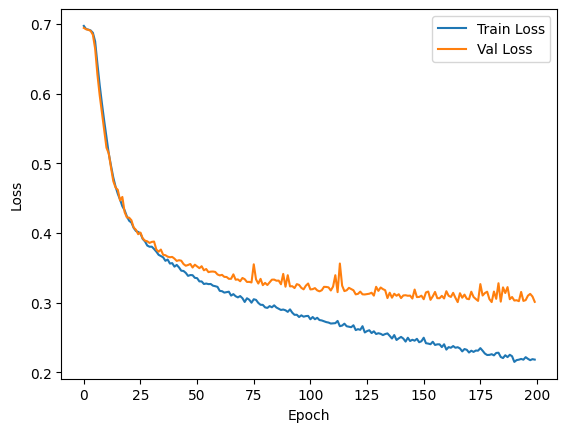

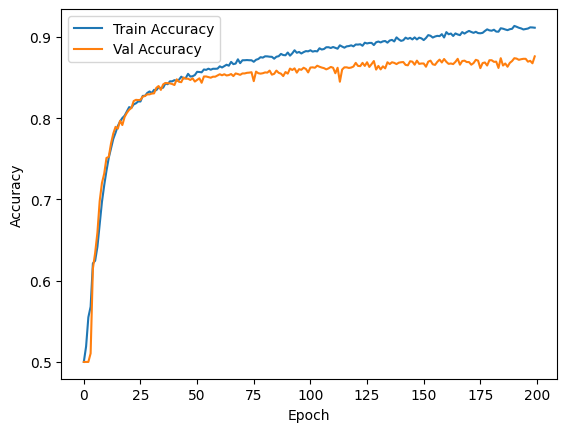

Test Accuracy: 0.8706


In [31]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 200
weight_decay = 2e-4

# Instantiate the model and move it to GPU
model = LSTM_c_dropout(embedding_dim=embedding_dim, vocab_size=frequentWord, hidden_dim=hidden_dim, output_dim=1).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # Unsqueeze to match dimensions
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels.unsqueeze(1)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()

# Convert y_test to the same data type as y_pred
y_test_np = y_test.values.astype(np.float32)

# Calculate test accuracy
test_accuracy = np.mean(y_pred.squeeze() == y_test_np)
print(f'Test Accuracy: {test_accuracy:.4f}')

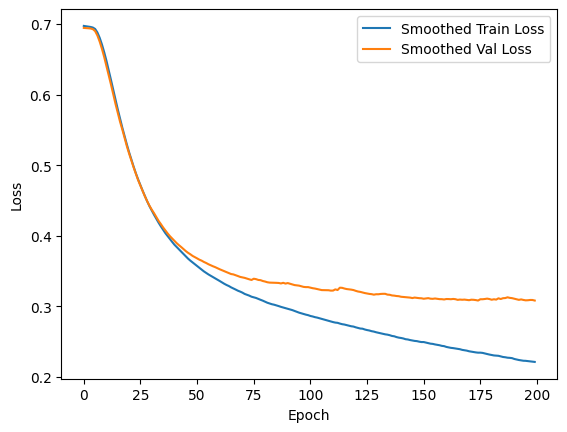

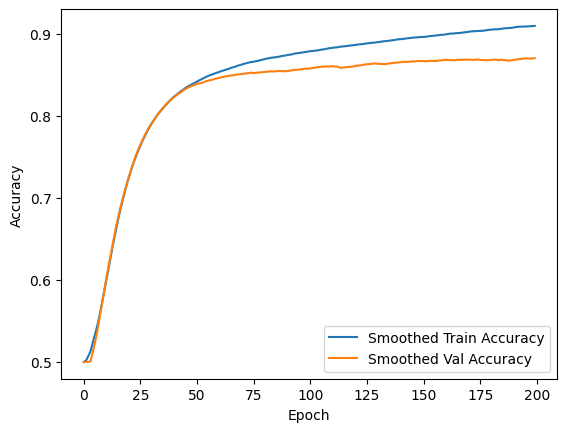

Test Accuracy: 0.8706


In [32]:
### Smoothing out the above graph
import numpy as np
import matplotlib.pyplot as plt

# Define a function for smoothing the data
def smooth_data(data, smoothing_factor=0.9):
    smoothed_data = []
    last_smoothed_point = data[0]
    for point in data:
        smoothed_point = last_smoothed_point * smoothing_factor + point * (1 - smoothing_factor)
        smoothed_data.append(smoothed_point)
        last_smoothed_point = smoothed_point
    return smoothed_data

# Smooth the train and validation losses
smoothed_train_losses = smooth_data(train_losses)
smoothed_val_losses = smooth_data(val_losses)

# Smooth the train and validation accuracies
smoothed_train_accuracies = smooth_data(train_accuracies)
smoothed_val_accuracies = smooth_data(val_accuracies)

# Plotting smoothed train and validation losses
plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
plt.plot(smoothed_val_losses, label='Smoothed Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting smoothed train and validation accuracies
plt.plot(smoothed_train_accuracies, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Smoothed Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate test accuracy
test_accuracy = np.mean(y_pred.squeeze() == y_test_np)
print(f'Test Accuracy: {test_accuracy:.4f}')

_____

_____

_____